In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow.lite as tflite
import tensorflowjs as tfjz
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import shutil
import zipfile
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2

## 2.1 Data Loading

In [3]:
# Buat folder dan pindahkan kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset The Simpsons Characters dari Kaggle
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

dataset_path = "/content/the-simpsons-characters-dataset.zip"
extract_path = "/content/the-simpsons-characters-dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak!")

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
License(s): CC-BY-NC-SA-4.0
100% 1.08G/1.08G [00:14<00:00, 57.6MB/s]
100% 1.08G/1.08G [00:14<00:00, 77.4MB/s]
Dataset berhasil diekstrak!


In [4]:
# Path dataset asli
data_dir = "/content/the-simpsons-characters-dataset/simpsons_dataset"
train_dir = "/content/simpsons_split/train"
test_dir = "/content/simpsons_split/test"

# Buat direktori train dan test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Pisahkan file ke train dan test
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        # List semua file gambar di folder karakter, pastikan hanya file yang valid
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Proses hanya jika folder memiliki gambar
        if len(images) > 0:
            train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

            # Buat subfolder per karakter di train dan test
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            # Pindahkan gambar ke train folder
            for img in train_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

            # Pindahkan gambar ke test folder
            for img in test_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("Dataset berhasil dipisahkan ke direktori train dan test.")


Dataset berhasil dipisahkan ke direktori train dan test.


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load ulang dataset tanpa mapping untuk mendapatkan class names
data_dir = "/content/the-simpsons-characters-dataset/simpsons_dataset"

raw_train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Simpan class names
class_names = raw_train_dataset.class_names
print("Class Names:", class_names)

# Normalisasi dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = raw_train_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 41866 files belonging to 43 classes.
Using 33493 files for training.
Class Names: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'simpsons_dataset', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


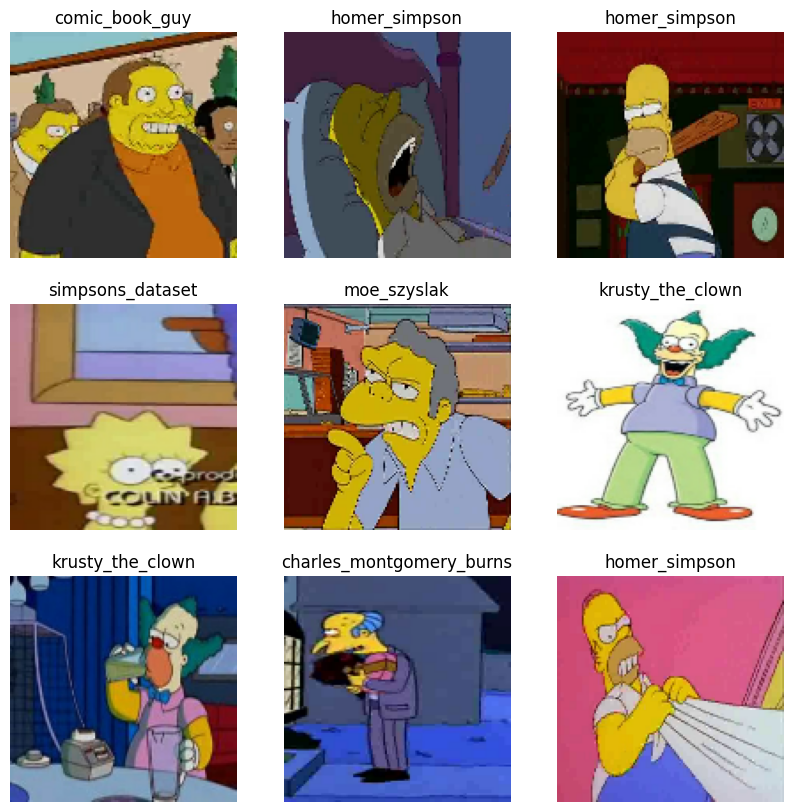

In [6]:
# Visualisasi data
plt.figure(figsize=(10, 10))
for images, labels in raw_train_dataset.take(1):  # Ambil dari dataset asli tanpa mapping
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


## 2.2 Data Preprocessing
## 2.2.1 Split Dataset

In [7]:
# Path ke direktori dataset
train_dir = "/content/simpsons_split/train"
test_dir = "/content/simpsons_split/test"

# Parameter untuk preprocessing
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Load dataset dan split otomatis
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Split 80% train, 20% validation
    subset="training",
    seed=42
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

print("Train batches:", train_dataset.cardinality().numpy())
print("Validation batches:", validation_dataset.cardinality().numpy())


Found 16727 files belonging to 42 classes.
Using 13382 files for training.
Found 16727 files belonging to 42 classes.
Using 3345 files for validation.
Train batches: 419
Validation batches: 105


In [8]:
# Data generator untuk train dan validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split dataset
)

# Train set
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Validation set
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 13398 images belonging to 42 classes.
Found 3329 images belonging to 42 classes.


## 3. MODELING

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load dataset dengan jumlah batch lebih kecil dan caching
data_dir = "/content/the-simpsons-characters-dataset/simpsons_dataset"

raw_train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=16  # Kurangi batch size agar tiap batch lebih cepat diproses
)

raw_validation_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

# Tambahkan prefetching agar loading data lebih cepat
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = raw_train_dataset.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

validation_dataset = raw_validation_dataset.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 41866 files belonging to 43 classes.
Using 33493 files for training.
Found 41866 files belonging to 43 classes.
Using 8373 files for validation.


In [10]:
# Model CNN yang lebih ringan
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(raw_train_dataset.class_names), activation='softmax')  # Output sesuai jumlah kelas
])

# Gunakan mixed precision untuk mempercepat komputasi
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Kompilasi model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Training dengan jumlah batch per epoch yang lebih kecil
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,  # Kurangi jumlah epoch jika terlalu lama
    steps_per_epoch=200,  # Batasi jumlah batch per epoch agar lebih cepat
    validation_steps=50,  # Batasi validasi batch
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4472 - loss: 2.9755

200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.4480 - loss: 2.9677 - val_accuracy: 0.5025 - val_loss: 2.2691
Epoch 2/10
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5089 - loss: 2.3488

200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5089 - loss: 2.3485 - val_accuracy: 0.5050 - val_loss: 2.1751
Epoch 3/10
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5217 - loss: 2.2514

200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5216 - loss: 2.2510 - val_accuracy: 0.4975 - val_loss: 2.1455
Epoch 4/10
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5220 - loss: 2.1604

200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5220 - loss: 2.1608 - val_accuracy: 0.5013 - val_loss: 2.0390
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.5064 - loss: 2.1926 - val_accuracy: 0.4975 - val_loss: 2.0411
Epoch 6/10
198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4919 - loss: 2.1526

200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4918 - loss: 2.1528 - val_accuracy: 0.4888 - val_loss: 2.0144
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5016 - loss: 2.0726

200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5016 - loss: 2.0725 - val_accuracy: 0.4888 - val_loss: 1.9320
Epoch 8/10
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4721 - loss: 2.1463

200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4722 - loss: 2.1459 - val_accuracy: 0.4975 - val_loss: 1.8871
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4963 - loss: 2.0002

200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.4962 - loss: 2.0002 - val_accuracy: 0.4975 - val_loss: 1.8320
Epoch 10/10
199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4992 - loss: 1.9372

200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4992 - loss: 1.9374 - val_accuracy: 0.4975 - val_loss: 1.8158


## 4. Evaluasi dan Visualisasi

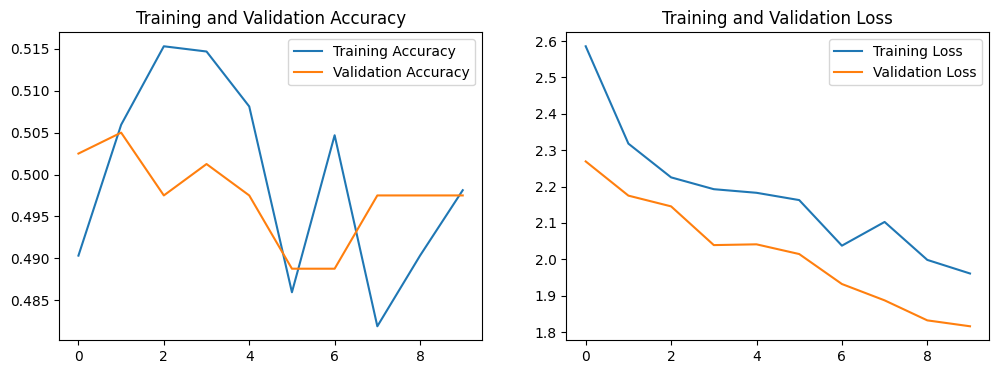

In [11]:
# Plot Akurasi
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


## 5. Konversi Model

In [12]:
# Save model dalam format SavedModel (gunakan .keras untuk format Keras atau .h5)
model.save('simpsons_model.keras')

# Save dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('simpsons_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save dalam format TFJS
!pip install tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'simpsons_model_tfjs')


Saved artifact at '/tmp/tmp0qj70zlp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  135348877314576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135346209913744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135346209913552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135346209914704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135346209912976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135346209912784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135346271679312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135346209914512: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file


## 6. Inference (Optional)

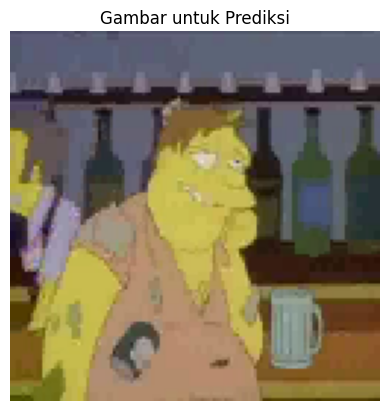

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: snake_jailbird


In [14]:
# Path gambar untuk inference
test_image_path = "/content/simpsons_split/test/barney_gumble/pic_0003.jpg"

# Pastikan file gambar ada
if not os.path.exists(test_image_path):
    raise FileNotFoundError(f"Gambar tidak ditemukan: {test_image_path}")

# Load dan proses gambar sesuai ukuran model (126, 126, 3)
target_size = (126, 126)
img = image.load_img(test_image_path, target_size=target_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Visualisasi gambar
plt.imshow(img)
plt.axis("off")
plt.title("Gambar untuk Prediksi")
plt.show()

# Load model Keras
loaded_model = tf.keras.models.load_model('simpsons_model.keras')

# Prediksi
predictions = loaded_model.predict(img_array)
predicted_class_index = np.argmax(predictions)

# Class names dari folder training
class_names = sorted(os.listdir("/content/simpsons_split/train"))
predicted_class = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class}")


In [15]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/simpsons_split/train",
    image_size=(126, 126),  # Resize gambar ke (126, 126)
    batch_size=32
)


Found 16727 files belonging to 42 classes.


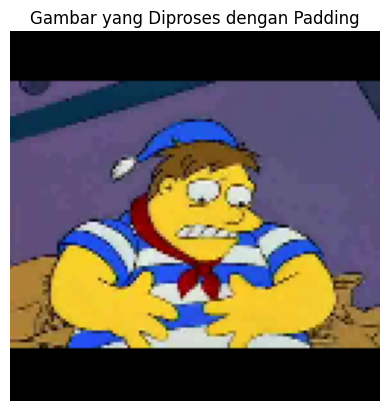

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
Predicted Class: snake_jailbird


In [19]:
def preprocess_with_padding(image_path, target_size=(126, 126)):
    """Load image and pad to target size without distortion."""
    img = image.load_img(image_path)
    img_array = image.img_to_array(img) / 255.0

    # Mendapatkan ukuran asli
    original_shape = img_array.shape[:2]

    # Resize proporsional tanpa merusak aspek rasio
    scale_factor = min(target_size[0] / original_shape[0], target_size[1] / original_shape[1])
    new_size = (int(original_shape[1] * scale_factor), int(original_shape[0] * scale_factor))

    # Resize gambar
    resized_img = cv2.resize(img_array, new_size)

    # Tambahkan padding untuk mencapai ukuran target
    delta_w = target_size[1] - resized_img.shape[1]
    delta_h = target_size[0] - resized_img.shape[0]

    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Tambahkan batch dimension
    padded_img = np.expand_dims(padded_img, axis=0)

    return padded_img

# Path gambar untuk inference
test_image_path = "/content/simpsons_split/test/barney_gumble/pic_0018.jpg"

# Pastikan file gambar ada
if not os.path.exists(test_image_path):
    raise FileNotFoundError(f"Gambar tidak ditemukan: {test_image_path}")

# Load dan preprocess gambar
img_array = preprocess_with_padding(test_image_path)

# Visualisasi gambar
plt.imshow(img_array[0])
plt.axis("off")
plt.title("Gambar yang Diproses dengan Padding")
plt.show()

# Load model Keras
loaded_model = tf.keras.models.load_model('simpsons_model.keras')

# Prediksi
predictions = loaded_model.predict(img_array)
predicted_class_index = np.argmax(predictions)

# Class names dari folder training
class_names = sorted(os.listdir("/content/simpsons_split/train"))
predicted_class = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class}")


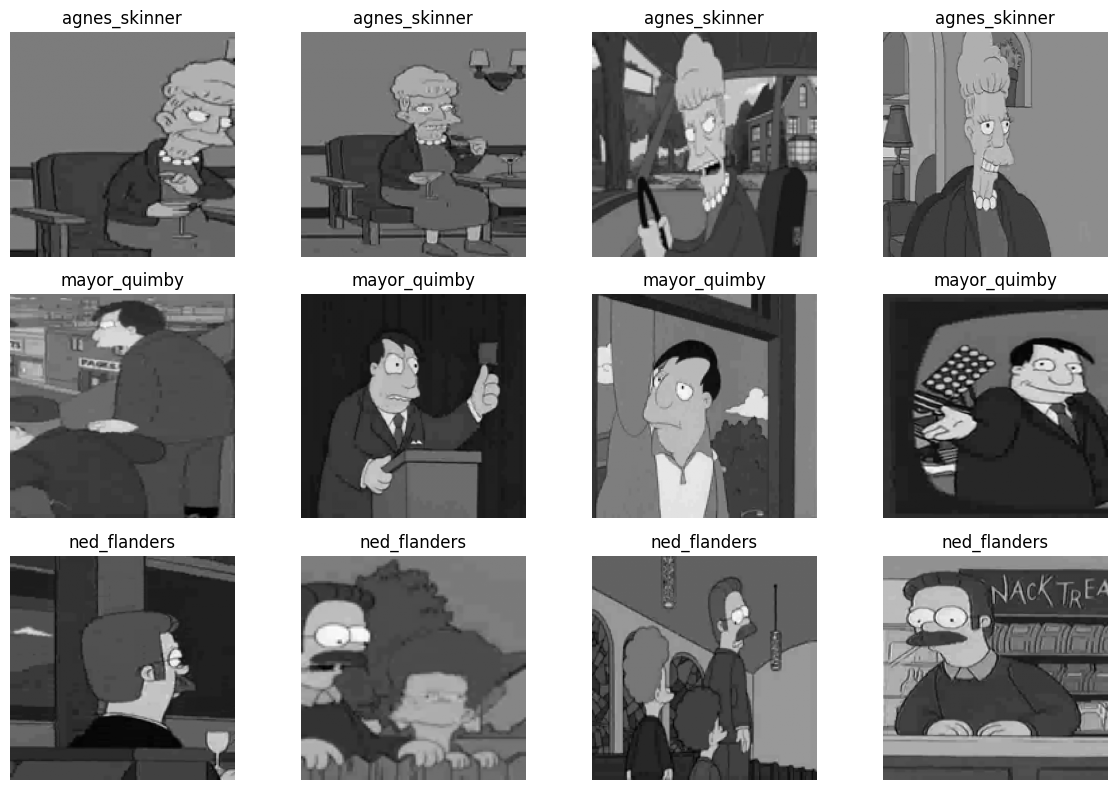

In [20]:
# Path dataset
path = "/content/simpsons_split"
path_sub = os.path.join(path, "train")

# Mengumpulkan daftar gambar per kelas
simpsons_images = {
    class_name: os.listdir(os.path.join(path_sub, class_name))
    for class_name in os.listdir(path_sub)
    if os.path.isdir(os.path.join(path_sub, class_name))
}

# Hanya tampilkan maksimal 3 kelas
selected_classes = list(simpsons_images.keys())[:3]

# Menampilkan gambar dengan ukuran berbeda
fig, axs = plt.subplots(len(selected_classes), 4, figsize=(12, 8))

for i, class_name in enumerate(selected_classes):
    # Pastikan jumlah gambar cukup
    num_images = min(4, len(simpsons_images[class_name]))
    images = np.random.choice(simpsons_images[class_name], num_images, replace=False)

    for j in range(4):
        axs[i, j].axis('off')  # Hilangkan axis jika tidak ada gambar
        if j < num_images:
            img_path = os.path.join(path_sub, class_name, images[j])
            img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan

            # Resize gambar ke ukuran acak
            random_size = np.random.randint(100, 200)  # Ukuran acak antara 100x100 hingga 200x200
            img = img.resize((random_size, random_size))

            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].set_title(class_name)

fig.tight_layout()
plt.show()
